In [40]:
# load 
import pandas as pd
from matplotlib import pyplot as plt


In [41]:
data_path = "processing/AITEX_cleaned_02.csv"
data_path = "processing/AITEX_clustering.csv"
data_path = "processing/AITEX_cluster_by_hand.csv"

df = pd.read_csv(data_path, sep=';')



In [42]:
# categorize Clustering
df['Cluster'] = df['Cluster'].astype('category')

array([[<AxesSubplot:title={'center':'Nº holes / Nº filaments'}>,
        <AxesSubplot:title={'center':'Diameter (mm)'}>,
        <AxesSubplot:title={'center':'L/D'}>,
        <AxesSubplot:title={'center':'Filter (um)'}>,
        <AxesSubplot:title={'center':'Sand quantity (cm)'}>],
       [<AxesSubplot:title={'center':'Support'}>,
        <AxesSubplot:title={'center':'Vpump (rpm)'}>,
        <AxesSubplot:title={'center':'Vext (rpm)'}>,
        <AxesSubplot:title={'center':'TE1 (°C)'}>,
        <AxesSubplot:title={'center':'TE2 (°C)'}>],
       [<AxesSubplot:title={'center':'TD(°C)'}>,
        <AxesSubplot:title={'center':'PD(bar)'}>,
        <AxesSubplot:title={'center':'PE(bar)'}>,
        <AxesSubplot:title={'center':'VTO (m/min)'}>,
        <AxesSubplot:title={'center':'VG1(m/min)'}>],
       [<AxesSubplot:title={'center':'VG2(m/min)'}>,
        <AxesSubplot:title={'center':'Vwinder (m/min)'}>,
        <AxesSubplot:title={'center':'Winder tension (N)'}>,
        <AxesSubplot:title=

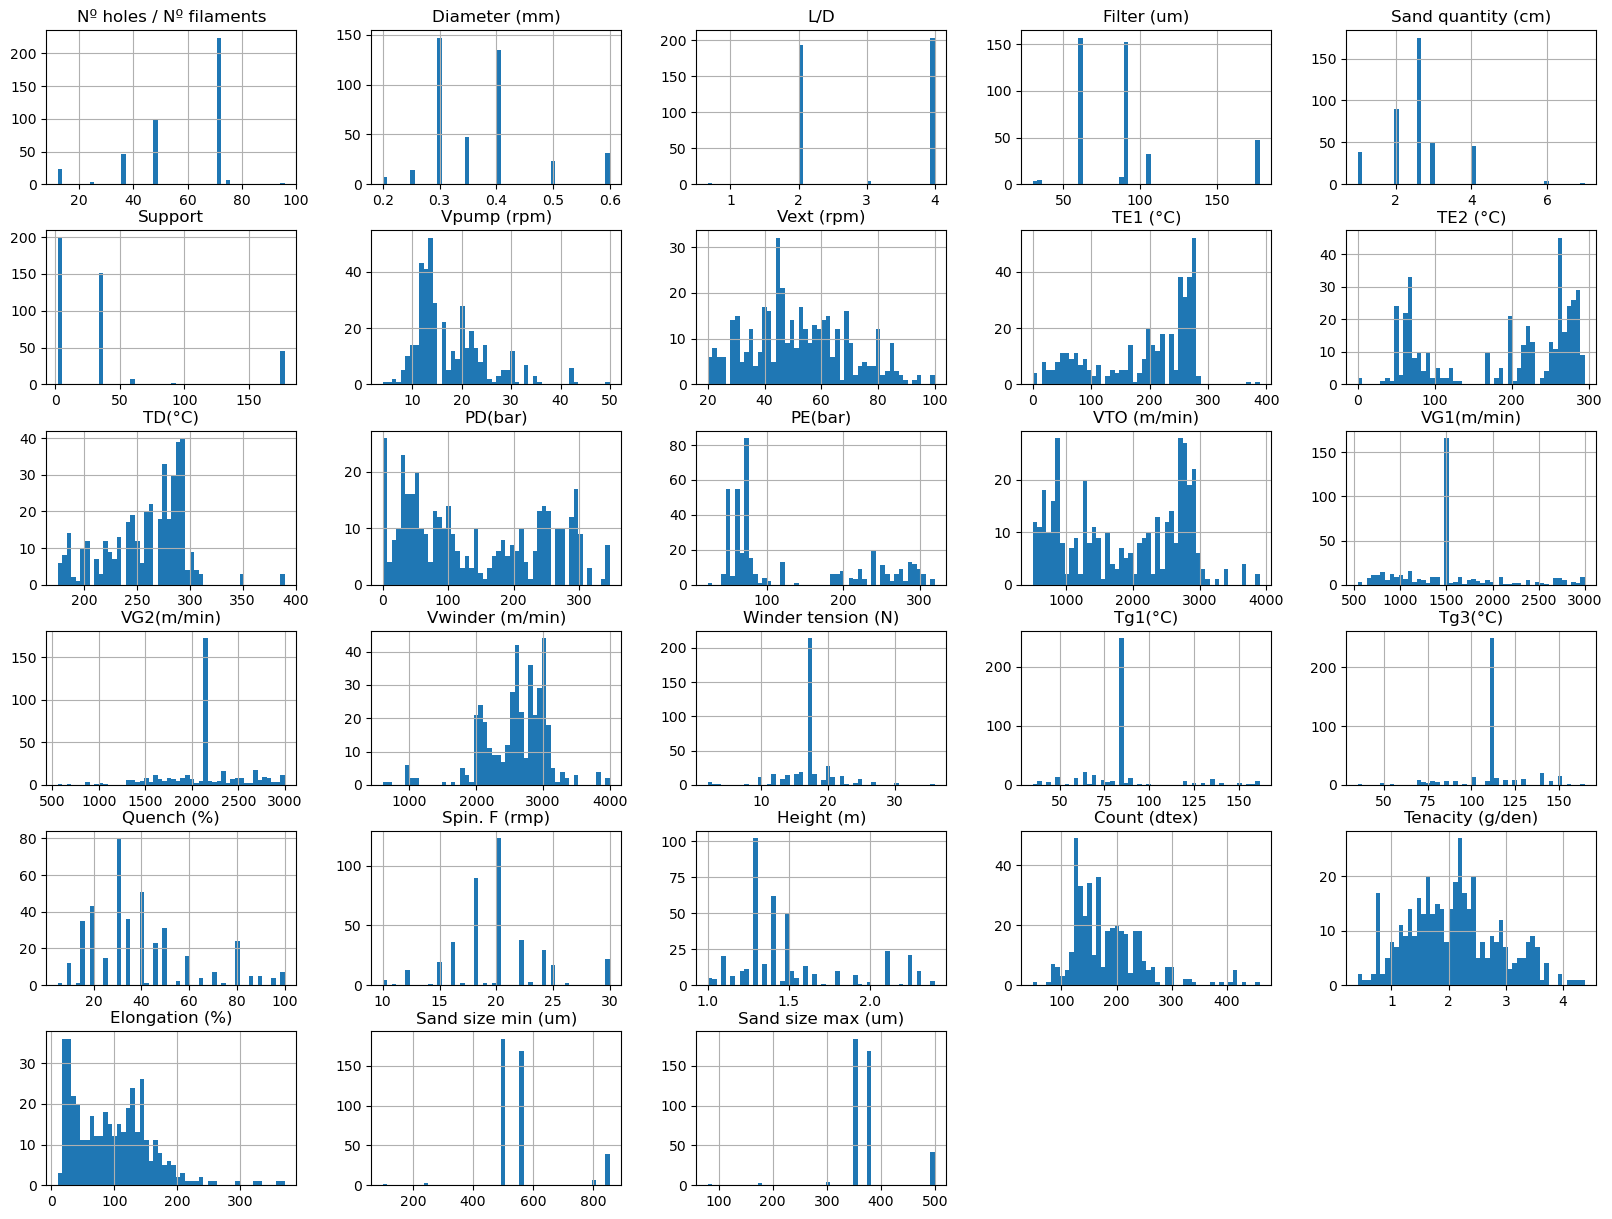

In [43]:
# hist 
df.hist(bins=50, figsize=(20,15))

In [44]:
len(df)

404

In [45]:
# remove elongation > 250
df = df[df["Elongation (%)"] < 225]
# Count (dtex)
df = df[df["Count (dtex)"] < 300]

In [46]:
material_uq = df["Material"].value_counts()
material_uq = material_uq[material_uq > 10].index.tolist()

# remove the materials with less than 10 samples
# df = df[df.groupby('Material').Material.transform('count') > 10]

# if the material is not in the list, then it is "other"

df["Material"] = df["Material"].apply(lambda x: x if x in material_uq else "other")

In [47]:
df["Material"].value_counts()

other            303
rPET              24
PHB DAN 04493     20
TPX               16
TPX DX350         12
Name: Material, dtype: int64

In [48]:
df.pop("Material")

0      other
1      other
2      other
3      other
4      other
       ...  
399    other
400    other
401    other
402    other
403    other
Name: Material, Length: 375, dtype: object

In [49]:
# Material
df = pd.get_dummies(df, columns=['Cluster'], prefix='Cluster')

In [50]:

outputs_list = ["Tenacity (g/den)"]
remove = ["Count (dtex)","Elongation (%)"]
inputs_list = set(df.columns) - set(outputs_list) - set(remove)
inputs_list = list(inputs_list)

df = df[inputs_list + outputs_list]

In [51]:
outputs_list

['Tenacity (g/den)']

In [52]:
inputs_list

['Sand quantity (cm)',
 'TD(°C)',
 'Height (m)',
 'PE(bar)',
 'Cluster_PBT',
 'Cluster_TPX',
 'TE2 (°C)',
 'Sand size max (um)',
 'Cluster_PLA',
 'Tg1(°C)',
 'Support',
 'Cluster_PHB',
 'Cluster_PET',
 'VTO (m/min)',
 'Cluster_PA',
 'TE1 (°C)',
 'Nº holes / Nº filaments',
 'Cluster_TPE',
 'Cluster_other',
 'Vpump (rpm)',
 'L/D',
 'Vwinder (m/min)',
 'VG1(m/min)',
 'Tg3(°C)',
 'PD(bar)',
 'Cluster_PES ',
 'Vext (rpm)',
 'Quench (%)',
 'Cluster_PP',
 'Diameter (mm)',
 'VG2(m/min)',
 'Cluster_PE ',
 'Cluster_ZK',
 'Spin. F (rmp)',
 'Filter (um)',
 'Winder tension (N)',
 'Sand size min (um)']

In [53]:
inputs_full  = df[inputs_list]
outputs_full = df[outputs_list]

# test 0.2
from sklearn.model_selection import train_test_split

inputs, inputs_test, outputs, outputs_test = train_test_split(inputs_full, outputs_full, test_size=0.2)

In [54]:
# normalize 
in_mu = inputs.mean()
in_std = inputs.std()

out_mu = outputs.mean()
out_std = outputs.std()

in_norm = (inputs - in_mu) / in_std
out_norm = (outputs - out_mu) / out_std

In [55]:
import torch 

# convert to tensor
in_norm = torch.tensor(in_norm.values, dtype=torch.float32)
out_norm = torch.tensor(out_norm.values, dtype=torch.float32)

In [56]:
class Net(torch.nn.Module):
    def __init__(self,hidden_size=50):
        super(Net, self).__init__()
        self.fc1 = torch.nn.Linear(in_norm.shape[1], hidden_size)

        self.fc2 = [torch.nn.Linear(hidden_size, hidden_size) for i in range(2)]
        self.fc3 = torch.nn.Linear(hidden_size, out_norm.shape[1])
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        for fc in self.fc2:
            x = torch.relu(fc(x))
        x = self.fc3(x)
        return x
  
    def compute_l1_loss(self, w):
        return torch.abs(w).sum()
    
    def compute_l2_loss(self, w):
        return torch.pow(w, 2).sum()
    

net = Net()

In [57]:
import torch

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)

batch_size = 128  # Tamaño de lote aleatorio
num_samples = in_norm.size(0)

for epoch in range(20000):

    # Selección aleatoria de índices
    indices = torch.randperm(num_samples)[:batch_size]
    in_batch = in_norm[indices]
    out_batch = out_norm[indices]

    optimizer.zero_grad()
    outputs_hat = net(in_batch)

    l1_weight = 0.0
    l2_weight = 1e-3

    # Regularización L2
    l2 = l2_weight * net.compute_l2_loss(net.fc1.weight)

    # Cálculo de la pérdida
    loss = criterion(outputs_hat, out_batch) + l2
    loss.backward()
    optimizer.step()

    # Mostrar la pérdida en cada 5000 épocas
    if epoch % 5000 == 0:
        loss_print = round(loss.item(), 4)
        print(f'epoch {epoch}, loss {loss_print}')

predicted = net(in_norm).detach().numpy()
predicted = predicted * out_std.values + out_mu.values


epoch 0, loss 1.0122
epoch 5000, loss 0.1278
epoch 10000, loss 0.0624
epoch 15000, loss 0.0396


In [58]:
import numpy as np
from sklearn.linear_model import LinearRegression


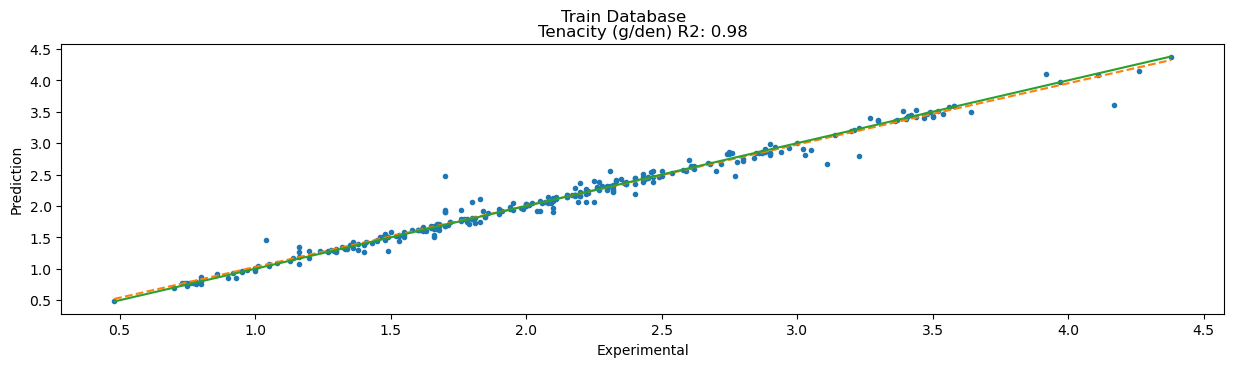

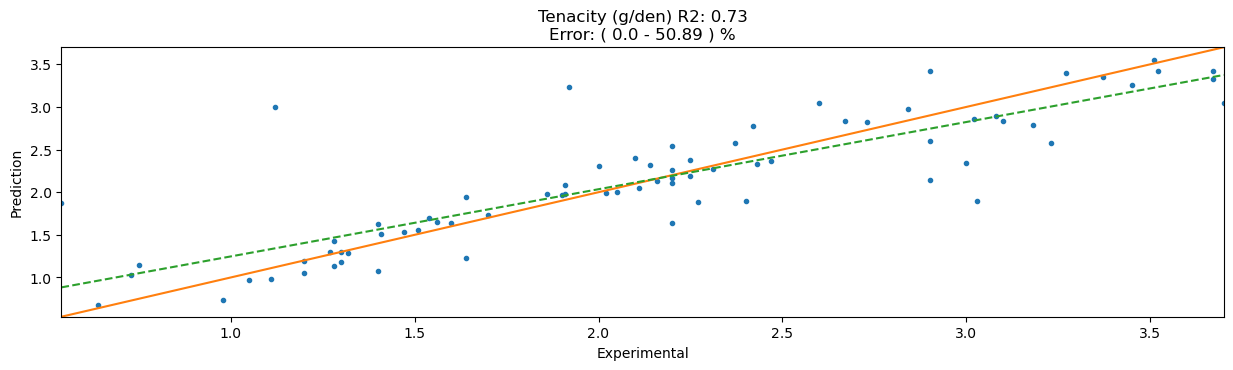

In [59]:
fig = plt.figure(figsize=(15,3.5))
for i in range(len(outputs.columns)):
    plt.subplot(1,len(outputs.columns),i+1)
    experimental = outputs.iloc[:,i].values


    plt.plot(experimental,predicted[:,i],'.')

    xspan = np.linspace(np.min(experimental),np.max(experimental),100)

    # reg
    reg = LinearRegression().fit(experimental.reshape(-1,1), predicted[:,i].reshape(-1,1))

    plt.plot(xspan, reg.predict(xspan.reshape(-1,1)), '--')


    plt.plot(xspan,xspan,'-')
# reg
    plt.title(f"{outputs.columns[i]} R2: {round(reg.score(experimental.reshape(-1,1), predicted[:,i].reshape(-1,1)),2)}")
    plt.xlabel("Experimental")
    plt.ylabel("Prediction")


in_norm_test = (inputs_test - in_mu) / in_std
in_norm_test = torch.tensor(in_norm_test.values, dtype=torch.float32)

predicted_test = net(in_norm_test).detach().numpy()

predicted_test = predicted_test * out_std.values + out_mu.values
plt.suptitle("Train Database")

# plot
fig = plt.figure(figsize=(15,3.5))

for i in range(len(outputs.columns)):
    plt.subplot(1,len(outputs.columns),i+1)
    experimental = outputs_test.iloc[:,i].values
    plt.plot(experimental,predicted_test[:,i],'.')

    xspan = np.linspace(np.min(experimental),np.max(experimental),100)

    plt.plot(xspan,xspan,'-')

    #plt.title(outputs.columns[i])

    plt.xlabel("Experimental")
    plt.ylabel("Prediction")

    plt.xlim([np.min(experimental),np.max(experimental)])
    plt.ylim([np.min(experimental),np.max(experimental)])
    

    # linear regression
    reg = LinearRegression().fit(experimental.reshape(-1,1), predicted_test[:,i].reshape(-1,1))

    plt.plot(xspan, reg.predict(xspan.reshape(-1,1)), '--')
    # title reg 

    
    error = np.abs(predicted_test - outputs_test.values)
    error = error / outputs_test.values * 100

    error_mu = error.mean()
    error_std = error.std()
    error_min = error_mu - error_std
    error_max = error_mu + error_std

    error_min = np.max([error_min,0])
    
    plt.title(f"{outputs.columns[i]} R2: {round(reg.score(experimental.reshape(-1,1), predicted_test[:,i].reshape(-1,1)),2)}\nError: ( {round(error_min,2)} - {round(error_max,2)} ) %")

# text Test Database


# Test

In [60]:
import optuna
import torch
import torch.nn as nn
import torch.optim as optim

# Define tu modelo de red

# Función objetivo para Optuna
def objective(trial):
    # Sugerir valores para los hiperparámetros
    hidden_dim = trial.suggest_int('hidden_dim', 16, 128)
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
    weight_decay = trial.suggest_loguniform('weight_decay', 1e-5, 1e-3)
    
    net = Net(hidden_dim)

    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)

    batch_size = 128  # Tamaño de lote aleatorio
    num_samples = in_norm.size(0)

    for epoch in range(2000):

        # Selección aleatoria de índices
        indices = torch.randperm(num_samples)[:batch_size]
        in_batch = in_norm[indices]
        out_batch = out_norm[indices]

        optimizer.zero_grad()
        outputs_hat = net(in_batch)

        l1_weight = 0.0
        l2_weight = 1e-3

        # Regularización L2
        l2 = l2_weight * net.compute_l2_loss(net.fc1.weight)

        # Cálculo de la pérdida
        loss = criterion(outputs_hat, out_batch) + l2
        loss.backward()
        optimizer.step()

        # Mostrar la pérdida en cada 5000 épocas
        if epoch % 500 == 0:
            loss_print = round(loss.item(), 4)
            print(f'epoch {epoch}, loss {loss_print}')

        predicted_test = net(in_norm_test).detach().numpy()
        predicted_test = predicted_test * out_std.values + out_mu.values

        error = np.abs(predicted_test - outputs_test.values)
        error = error / outputs_test.values
        error = error.mean()

    return error



# Crear un estudio de Optuna
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)  # Número de pruebas

#save in external file

# Mejores hiperparámetros encontrados
print("Best hyperparameters:", study.best_params)
best_params = study.best_params


[I 2024-11-04 09:07:49,571] A new study created in memory with name: no-name-452a777f-8202-4da2-a777-e1573596e042
/tmp/ipykernel_758140/3938990889.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
/tmp/ipykernel_758140/3938990889.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-5, 1e-3)


epoch 0, loss 1.03
epoch 500, loss 0.0567
epoch 1000, loss 0.0561
epoch 1500, loss 0.0525


[I 2024-11-04 09:07:50,872] Trial 0 finished with value: 0.16158954490860358 and parameters: {'hidden_dim': 75, 'lr': 0.027112939014982337, 'weight_decay': 0.00020632236922716742}. Best is trial 0 with value: 0.16158954490860358.


epoch 0, loss 1.048
epoch 500, loss 1.1187
epoch 1000, loss 0.8889
epoch 1500, loss 0.893


[I 2024-11-04 09:07:52,297] Trial 1 finished with value: 0.39913189893518114 and parameters: {'hidden_dim': 86, 'lr': 1.2195389731101728e-05, 'weight_decay': 3.010829079990832e-05}. Best is trial 0 with value: 0.16158954490860358.


epoch 0, loss 0.9421
epoch 500, loss 0.0846
epoch 1000, loss 0.0559
epoch 1500, loss 0.0394


[I 2024-11-04 09:07:53,683] Trial 2 finished with value: 0.15544233902738447 and parameters: {'hidden_dim': 88, 'lr': 0.001399459818146697, 'weight_decay': 2.7001147940786576e-05}. Best is trial 2 with value: 0.15544233902738447.


epoch 0, loss 1.0988
epoch 500, loss 0.1436
epoch 1000, loss 0.1091
epoch 1500, loss 0.0682


[I 2024-11-04 09:07:54,800] Trial 3 finished with value: 0.17152159590428043 and parameters: {'hidden_dim': 16, 'lr': 0.0020520966559971756, 'weight_decay': 7.489251372024278e-05}. Best is trial 2 with value: 0.15544233902738447.


epoch 0, loss 1.0876
epoch 500, loss 0.045
epoch 1000, loss 0.0345
epoch 1500, loss 0.0317


[I 2024-11-04 09:07:56,345] Trial 4 finished with value: 0.15763596415848388 and parameters: {'hidden_dim': 123, 'lr': 0.010125428659983466, 'weight_decay': 0.0002501576279379336}. Best is trial 2 with value: 0.15544233902738447.


epoch 0, loss 1.056
epoch 500, loss 1.0348
epoch 1000, loss 0.7033
epoch 1500, loss 0.48


[I 2024-11-04 09:07:57,869] Trial 5 finished with value: 0.2594028880040015 and parameters: {'hidden_dim': 106, 'lr': 5.4282212870320823e-05, 'weight_decay': 0.00014396645967408816}. Best is trial 2 with value: 0.15544233902738447.


epoch 0, loss 0.9935
epoch 500, loss 0.072
epoch 1000, loss 0.0407
epoch 1500, loss 0.0376


[I 2024-11-04 09:07:59,024] Trial 6 finished with value: 0.15516579285909265 and parameters: {'hidden_dim': 40, 'lr': 0.002292259864039747, 'weight_decay': 1.7250422551763076e-05}. Best is trial 6 with value: 0.15516579285909265.


epoch 0, loss 0.9936
epoch 500, loss 0.0465
epoch 1000, loss 0.0279
epoch 1500, loss 0.0303


[I 2024-11-04 09:08:00,634] Trial 7 finished with value: 0.1641495104293824 and parameters: {'hidden_dim': 116, 'lr': 0.006501073740346423, 'weight_decay': 5.180716167244193e-05}. Best is trial 6 with value: 0.15516579285909265.


epoch 0, loss 1.1062
epoch 500, loss 0.0541
epoch 1000, loss 0.0366
epoch 1500, loss 0.0381


[I 2024-11-04 09:08:02,049] Trial 8 finished with value: 0.14525340978015785 and parameters: {'hidden_dim': 88, 'lr': 0.0023428327762708098, 'weight_decay': 0.00032485317959958347}. Best is trial 8 with value: 0.14525340978015785.


epoch 0, loss 1.0705
epoch 500, loss 0.7768
epoch 1000, loss 0.7413
epoch 1500, loss 0.5222


[I 2024-11-04 09:08:03,161] Trial 9 finished with value: 0.2711526679177522 and parameters: {'hidden_dim': 23, 'lr': 9.841149196031021e-05, 'weight_decay': 0.00035982992232800655}. Best is trial 8 with value: 0.14525340978015785.


epoch 0, loss 1.1244
epoch 500, loss 0.1445
epoch 1000, loss 0.1799
epoch 1500, loss 0.1123


[I 2024-11-04 09:08:04,375] Trial 10 finished with value: 0.1625348450435207 and parameters: {'hidden_dim': 53, 'lr': 0.09770849553517301, 'weight_decay': 0.0009671603339885723}. Best is trial 8 with value: 0.14525340978015785.


epoch 0, loss 0.796
epoch 500, loss 0.2503
epoch 1000, loss 0.1101
epoch 1500, loss 0.0968


[I 2024-11-04 09:08:05,575] Trial 11 finished with value: 0.17575895046777823 and parameters: {'hidden_dim': 47, 'lr': 0.0004665582978341478, 'weight_decay': 1.3149924327130377e-05}. Best is trial 8 with value: 0.14525340978015785.


epoch 0, loss 1.0341
epoch 500, loss 0.2349
epoch 1000, loss 0.1428
epoch 1500, loss 0.1265


[I 2024-11-04 09:08:06,787] Trial 12 finished with value: 0.1468233507783337 and parameters: {'hidden_dim': 49, 'lr': 0.0005120699047888741, 'weight_decay': 9.252834031075313e-05}. Best is trial 8 with value: 0.14525340978015785.


epoch 0, loss 1.0552
epoch 500, loss 0.1947
epoch 1000, loss 0.1069
epoch 1500, loss 0.0727


[I 2024-11-04 09:08:08,029] Trial 13 finished with value: 0.15643068189876969 and parameters: {'hidden_dim': 66, 'lr': 0.0005324427565083543, 'weight_decay': 0.00010341420637685393}. Best is trial 8 with value: 0.14525340978015785.


epoch 0, loss 1.1633
epoch 500, loss 0.2339
epoch 1000, loss 0.1598
epoch 1500, loss 0.1278


[I 2024-11-04 09:08:09,523] Trial 14 finished with value: 0.1538794777441546 and parameters: {'hidden_dim': 97, 'lr': 0.000267320932543281, 'weight_decay': 0.0003908070710296037}. Best is trial 8 with value: 0.14525340978015785.


epoch 0, loss 1.2892
epoch 500, loss 0.0584
epoch 1000, loss 0.0381
epoch 1500, loss 0.0382


[I 2024-11-04 09:08:10,819] Trial 15 finished with value: 0.14014532358627788 and parameters: {'hidden_dim': 66, 'lr': 0.004174009875912105, 'weight_decay': 6.465121366347504e-05}. Best is trial 15 with value: 0.14014532358627788.


epoch 0, loss 0.9839
epoch 500, loss 0.0451
epoch 1000, loss 0.0346
epoch 1500, loss 0.0243


[I 2024-11-04 09:08:12,139] Trial 16 finished with value: 0.16709496404657592 and parameters: {'hidden_dim': 70, 'lr': 0.0035368856471194162, 'weight_decay': 5.167022267853921e-05}. Best is trial 15 with value: 0.14014532358627788.


epoch 0, loss 1.0437
epoch 500, loss 0.0344
epoch 1000, loss 0.0362
epoch 1500, loss 0.05


[I 2024-11-04 09:08:13,566] Trial 17 finished with value: 0.15655797741380018 and parameters: {'hidden_dim': 83, 'lr': 0.011999975760977848, 'weight_decay': 0.00016514790285645137}. Best is trial 15 with value: 0.14014532358627788.


epoch 0, loss 1.0305
epoch 500, loss 0.0492
epoch 1000, loss 0.0539
epoch 1500, loss 0.0373


[I 2024-11-04 09:08:14,854] Trial 18 finished with value: 0.15015327620928345 and parameters: {'hidden_dim': 59, 'lr': 0.004086463705792685, 'weight_decay': 0.0005666746900268202}. Best is trial 15 with value: 0.14014532358627788.


epoch 0, loss 0.8498
epoch 500, loss 0.0797
epoch 1000, loss 0.0693
epoch 1500, loss 0.0509


[I 2024-11-04 09:08:16,363] Trial 19 finished with value: 0.15018109340223995 and parameters: {'hidden_dim': 103, 'lr': 0.0011569070900345638, 'weight_decay': 0.00011628801491841035}. Best is trial 15 with value: 0.14014532358627788.


epoch 0, loss 1.0615
epoch 500, loss 0.0544
epoch 1000, loss 0.0366
epoch 1500, loss 0.0489


[I 2024-11-04 09:08:17,485] Trial 20 finished with value: 0.15487154024405866 and parameters: {'hidden_dim': 36, 'lr': 0.022714365468542264, 'weight_decay': 0.00023023618622032812}. Best is trial 15 with value: 0.14014532358627788.


epoch 0, loss 0.9286
epoch 500, loss 0.1231
epoch 1000, loss 0.0822
epoch 1500, loss 0.0671


[I 2024-11-04 09:08:18,710] Trial 21 finished with value: 0.16181065472975315 and parameters: {'hidden_dim': 61, 'lr': 0.0008018200074114632, 'weight_decay': 7.195510115405972e-05}. Best is trial 15 with value: 0.14014532358627788.


epoch 0, loss 0.924
epoch 500, loss 0.0568
epoch 1000, loss 0.0428
epoch 1500, loss 0.0294


[I 2024-11-04 09:08:20,015] Trial 22 finished with value: 0.13415670287093864 and parameters: {'hidden_dim': 76, 'lr': 0.0020391133942105556, 'weight_decay': 0.00014257032549852905}. Best is trial 22 with value: 0.13415670287093864.


epoch 0, loss 1.1984
epoch 500, loss 0.0502
epoch 1000, loss 0.0346
epoch 1500, loss 0.0298


[I 2024-11-04 09:08:21,372] Trial 23 finished with value: 0.16348383000229552 and parameters: {'hidden_dim': 76, 'lr': 0.004174267414574716, 'weight_decay': 0.00014760580726237514}. Best is trial 22 with value: 0.13415670287093864.


epoch 0, loss 0.9329
epoch 500, loss 0.0534
epoch 1000, loss 0.0426
epoch 1500, loss 0.0277


[I 2024-11-04 09:08:22,829] Trial 24 finished with value: 0.16326083248303672 and parameters: {'hidden_dim': 94, 'lr': 0.0017718549653404293, 'weight_decay': 0.0002818384432616204}. Best is trial 22 with value: 0.13415670287093864.


epoch 0, loss 0.9494
epoch 500, loss 0.0451
epoch 1000, loss 0.0393
epoch 1500, loss 0.0257


[I 2024-11-04 09:08:24,169] Trial 25 finished with value: 0.166911679213488 and parameters: {'hidden_dim': 71, 'lr': 0.0030637132996175105, 'weight_decay': 0.0001741925571143347}. Best is trial 22 with value: 0.13415670287093864.


epoch 0, loss 0.9812
epoch 500, loss 0.0504
epoch 1000, loss 0.0402
epoch 1500, loss 0.0299


[I 2024-11-04 09:08:25,613] Trial 26 finished with value: 0.1649586724556692 and parameters: {'hidden_dim': 82, 'lr': 0.0076599225516694285, 'weight_decay': 0.00012326365032812715}. Best is trial 22 with value: 0.13415670287093864.


epoch 0, loss 1.2444
epoch 500, loss 0.1055
epoch 1000, loss 0.0475
epoch 1500, loss 0.0553


[I 2024-11-04 09:08:27,110] Trial 27 finished with value: 0.15422380953268414 and parameters: {'hidden_dim': 112, 'lr': 0.0009621181604103627, 'weight_decay': 0.0003407809142390898}. Best is trial 22 with value: 0.13415670287093864.


epoch 0, loss 1.0184
epoch 500, loss 0.0823
epoch 1000, loss 0.0509
epoch 1500, loss 0.0398


[I 2024-11-04 09:08:28,515] Trial 28 finished with value: 0.15377393836972575 and parameters: {'hidden_dim': 95, 'lr': 0.001779943094867248, 'weight_decay': 0.0002005601755469101}. Best is trial 22 with value: 0.13415670287093864.


epoch 0, loss 0.9736
epoch 500, loss 0.0481
epoch 1000, loss 0.0497
epoch 1500, loss 0.0449


[I 2024-11-04 09:08:29,831] Trial 29 finished with value: 0.16118935787390748 and parameters: {'hidden_dim': 78, 'lr': 0.017387385621384012, 'weight_decay': 0.00020061074229492086}. Best is trial 22 with value: 0.13415670287093864.


epoch 0, loss 0.9531
epoch 500, loss 0.0969
epoch 1000, loss 0.0741
epoch 1500, loss 0.0951


[I 2024-11-04 09:08:31,033] Trial 30 finished with value: 0.16722271087676235 and parameters: {'hidden_dim': 64, 'lr': 0.03881412436662441, 'weight_decay': 8.585960318861565e-05}. Best is trial 22 with value: 0.13415670287093864.


epoch 0, loss 1.0226
epoch 500, loss 0.0546
epoch 1000, loss 0.0345
epoch 1500, loss 0.04


[I 2024-11-04 09:08:32,209] Trial 31 finished with value: 0.15483035148166918 and parameters: {'hidden_dim': 50, 'lr': 0.006124810403569697, 'weight_decay': 9.7424932720447e-05}. Best is trial 22 with value: 0.13415670287093864.


epoch 0, loss 0.9439
epoch 500, loss 0.1947
epoch 1000, loss 0.07
epoch 1500, loss 0.0572


[I 2024-11-04 09:08:33,346] Trial 32 finished with value: 0.1550561601470727 and parameters: {'hidden_dim': 40, 'lr': 0.0006363330024701078, 'weight_decay': 5.681037599896625e-05}. Best is trial 22 with value: 0.13415670287093864.


epoch 0, loss 0.9109
epoch 500, loss 0.2856
epoch 1000, loss 0.175
epoch 1500, loss 0.0907


[I 2024-11-04 09:08:34,565] Trial 33 finished with value: 0.17204196642208724 and parameters: {'hidden_dim': 57, 'lr': 0.00029809496858047363, 'weight_decay': 3.7619805800022465e-05}. Best is trial 22 with value: 0.13415670287093864.


epoch 0, loss 0.9568
epoch 500, loss 0.1108
epoch 1000, loss 0.0453
epoch 1500, loss 0.043


[I 2024-11-04 09:08:35,917] Trial 34 finished with value: 0.14449507050163823 and parameters: {'hidden_dim': 88, 'lr': 0.0012417910207835627, 'weight_decay': 7.665709256902907e-05}. Best is trial 22 with value: 0.13415670287093864.


epoch 0, loss 1.0314
epoch 500, loss 0.1062
epoch 1000, loss 0.0602
epoch 1500, loss 0.0515


[I 2024-11-04 09:08:37,264] Trial 35 finished with value: 0.15356817865299974 and parameters: {'hidden_dim': 90, 'lr': 0.0013023385173781491, 'weight_decay': 7.011510428725726e-05}. Best is trial 22 with value: 0.13415670287093864.


epoch 0, loss 1.0891
epoch 500, loss 0.0677
epoch 1000, loss 0.0524
epoch 1500, loss 0.0289


[I 2024-11-04 09:08:38,650] Trial 36 finished with value: 0.16115665762657574 and parameters: {'hidden_dim': 88, 'lr': 0.002359046561904678, 'weight_decay': 3.634727003683658e-05}. Best is trial 22 with value: 0.13415670287093864.


epoch 0, loss 1.0023
epoch 500, loss 0.0361
epoch 1000, loss 0.0396
epoch 1500, loss 0.0276


[I 2024-11-04 09:08:40,091] Trial 37 finished with value: 0.17003702204207222 and parameters: {'hidden_dim': 102, 'lr': 0.0047059480849973275, 'weight_decay': 0.00011701168895515235}. Best is trial 22 with value: 0.13415670287093864.


epoch 0, loss 1.0667
epoch 500, loss 0.0825
epoch 1000, loss 0.0489
epoch 1500, loss 0.0422


[I 2024-11-04 09:08:41,395] Trial 38 finished with value: 0.16399261044882993 and parameters: {'hidden_dim': 75, 'lr': 0.002383288818708038, 'weight_decay': 2.6867012403153356e-05}. Best is trial 22 with value: 0.13415670287093864.


epoch 0, loss 1.0204
epoch 500, loss 0.0935
epoch 1000, loss 0.0412
epoch 1500, loss 0.0379


[I 2024-11-04 09:08:42,778] Trial 39 finished with value: 0.17157639813164308 and parameters: {'hidden_dim': 85, 'lr': 0.0015858408046024617, 'weight_decay': 0.0001467692214182966}. Best is trial 22 with value: 0.13415670287093864.


epoch 0, loss 0.9184
epoch 500, loss 0.0388
epoch 1000, loss 0.0531
epoch 1500, loss 0.033


[I 2024-11-04 09:08:44,332] Trial 40 finished with value: 0.14446659775422957 and parameters: {'hidden_dim': 128, 'lr': 0.010952557688666677, 'weight_decay': 6.444574595197322e-05}. Best is trial 22 with value: 0.13415670287093864.


epoch 0, loss 1.1678
epoch 500, loss 0.0435
epoch 1000, loss 0.0391
epoch 1500, loss 0.027


[I 2024-11-04 09:08:45,879] Trial 41 finished with value: 0.15159609807377677 and parameters: {'hidden_dim': 128, 'lr': 0.010867029618282042, 'weight_decay': 6.254739079274766e-05}. Best is trial 22 with value: 0.13415670287093864.


epoch 0, loss 0.9833
epoch 500, loss 0.0422
epoch 1000, loss 0.037
epoch 1500, loss 0.0276


[I 2024-11-04 09:08:47,204] Trial 42 finished with value: 0.1533822207240301 and parameters: {'hidden_dim': 79, 'lr': 0.007290276840032185, 'weight_decay': 7.999984938156669e-05}. Best is trial 22 with value: 0.13415670287093864.


epoch 0, loss 1.0488
epoch 500, loss 0.0691
epoch 1000, loss 0.0449
epoch 1500, loss 0.0243


[I 2024-11-04 09:08:48,792] Trial 43 finished with value: 0.15807785091619153 and parameters: {'hidden_dim': 117, 'lr': 0.0031196003272204783, 'weight_decay': 4.525410099308757e-05}. Best is trial 22 with value: 0.13415670287093864.


epoch 0, loss 0.8994
epoch 500, loss 0.0976
epoch 1000, loss 0.0513
epoch 1500, loss 0.0426


[I 2024-11-04 09:08:50,312] Trial 44 finished with value: 0.15095253671671613 and parameters: {'hidden_dim': 108, 'lr': 0.0011420554866808793, 'weight_decay': 6.818765860680104e-05}. Best is trial 22 with value: 0.13415670287093864.


epoch 0, loss 0.8862
epoch 500, loss 0.0428
epoch 1000, loss 0.0354
epoch 1500, loss 0.0289


[I 2024-11-04 09:08:51,572] Trial 45 finished with value: 0.16499501021114946 and parameters: {'hidden_dim': 68, 'lr': 0.0054591304330100674, 'weight_decay': 8.346448014675126e-05}. Best is trial 22 with value: 0.13415670287093864.


epoch 0, loss 0.8908
epoch 500, loss 0.0547
epoch 1000, loss 0.0568
epoch 1500, loss 0.0373


[I 2024-11-04 09:08:52,662] Trial 46 finished with value: 0.15327247955607395 and parameters: {'hidden_dim': 29, 'lr': 0.0029559014502110654, 'weight_decay': 0.00010348684004311331}. Best is trial 22 with value: 0.13415670287093864.


epoch 0, loss 1.1341
epoch 500, loss 0.0589
epoch 1000, loss 0.0396
epoch 1500, loss 0.0345


[I 2024-11-04 09:08:54,258] Trial 47 finished with value: 0.15557329714213275 and parameters: {'hidden_dim': 121, 'lr': 0.0022042971361839027, 'weight_decay': 5.9629126156506046e-05}. Best is trial 22 with value: 0.13415670287093864.


epoch 0, loss 0.9826
epoch 500, loss 0.0467
epoch 1000, loss 0.0351
epoch 1500, loss 0.0276


[I 2024-11-04 09:08:55,688] Trial 48 finished with value: 0.1609029953688929 and parameters: {'hidden_dim': 99, 'lr': 0.008277623167844294, 'weight_decay': 4.6791388797135525e-05}. Best is trial 22 with value: 0.13415670287093864.


epoch 0, loss 0.8011
epoch 500, loss 0.0418
epoch 1000, loss 0.0514
epoch 1500, loss 0.0385


[I 2024-11-04 09:08:57,041] Trial 49 finished with value: 0.16847731451565348 and parameters: {'hidden_dim': 91, 'lr': 0.012429130155973332, 'weight_decay': 0.00012139797789217159}. Best is trial 22 with value: 0.13415670287093864.


Best hyperparameters: {'hidden_dim': 76, 'lr': 0.0020391133942105556, 'weight_decay': 0.00014257032549852905}


In [61]:
import torch

# Crear y entrenar el modelo con los mejores hiperparámetros
hidden_dim = best_params['hidden_dim']
lr = best_params['lr']
weight_decay = best_params['weight_decay']

model = Net(hidden_dim)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)

batch_size = 128  # Tamaño de lote aleatorio
num_samples = in_norm.size(0)

for epoch in range(40000):

    # Selección aleatoria de índices
    indices = torch.randperm(num_samples)[:batch_size]
    in_batch = in_norm[indices]
    out_batch = out_norm[indices]

    optimizer.zero_grad()
    outputs_hat = net(in_batch)

    l1_weight = 0.0
    l2_weight = 1e-3

    # Regularización L2
    l2 = l2_weight * net.compute_l2_loss(net.fc1.weight)

    # Cálculo de la pérdida
    loss = criterion(outputs_hat, out_batch) + l2
    loss.backward()
    optimizer.step()

    # Mostrar la pérdida en cada 5000 épocas
    if epoch % 5000 == 0:
        loss_print = round(loss.item(), 4)
        print(f'epoch {epoch}, loss {loss_print}')

predicted = net(in_norm).detach().numpy()
predicted = predicted * out_std.values + out_mu.values


epoch 0, loss 0.0274
epoch 5000, loss 0.0174
epoch 10000, loss 0.0158
epoch 15000, loss 0.0126
epoch 20000, loss 0.0217
epoch 25000, loss 0.0126
epoch 30000, loss 0.0126
epoch 35000, loss 0.0145


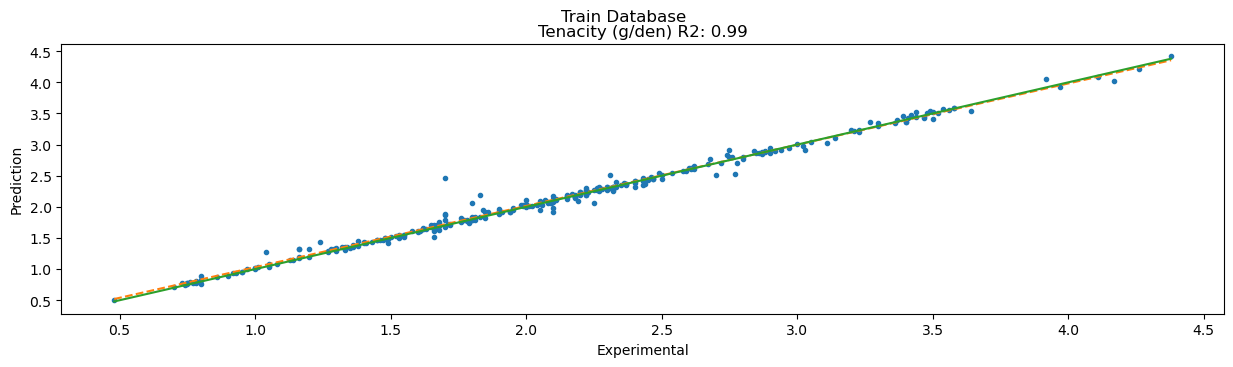

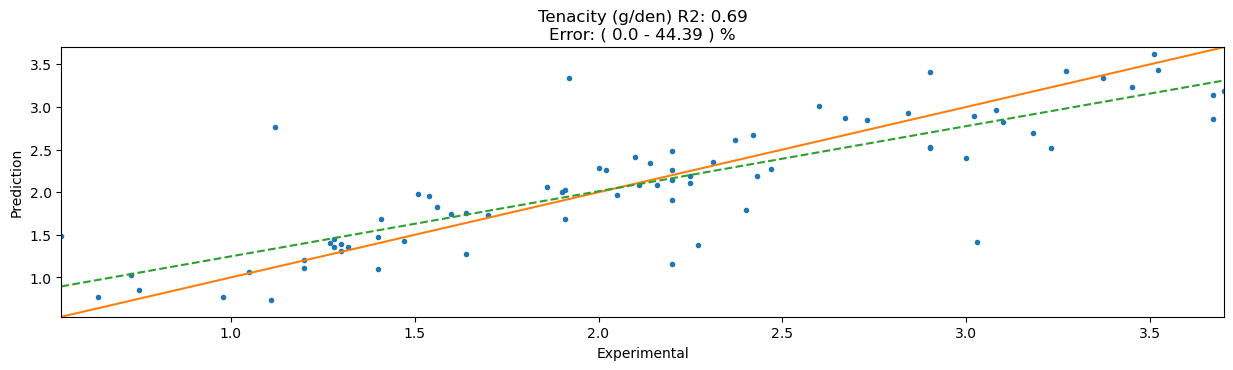

In [ ]:
fig = plt.figure(figsize=(15,3.5))
for i in range(len(outputs.columns)):
    plt.subplot(1,len(outputs.columns),i+1)
    experimental = outputs.iloc[:,i].values


    plt.plot(experimental,predicted[:,i],'.')

    xspan = np.linspace(np.min(experimental),np.max(experimental),100)

    # reg
    reg = LinearRegression().fit(experimental.reshape(-1,1), predicted[:,i].reshape(-1,1))

    plt.plot(xspan, reg.predict(xspan.reshape(-1,1)), '--')


    plt.plot(xspan,xspan,'-')
# reg
    plt.title(f"{outputs.columns[i]} R2: {round(reg.score(experimental.reshape(-1,1), predicted[:,i].reshape(-1,1)),2)}")
    plt.xlabel("Experimental")
    plt.ylabel("Prediction")


in_norm_test = (inputs_test - in_mu) / in_std
in_norm_test = torch.tensor(in_norm_test.values, dtype=torch.float32)

predicted_test = net(in_norm_test).detach().numpy()

predicted_test = predicted_test * out_std.values + out_mu.values
plt.suptitle("Train Database")

# plot
fig = plt.figure(figsize=(15,3.5))

for i in range(len(outputs.columns)):
    plt.subplot(2,len(outputs.columns),i+1)
    experimental = outputs_test.iloc[:,i].values
    plt.plot(experimental,predicted_test[:,i],'.')

    xspan = np.linspace(np.min(experimental),np.max(experimental),100)

    plt.plot(xspan,xspan,'-')

    #plt.title(outputs.columns[i])

    plt.xlabel("Experimental")
    plt.ylabel("Prediction")

    plt.xlim([np.min(experimental),np.max(experimental)])
    plt.ylim([np.min(experimental),np.max(experimental)])
    

    # linear regression
    reg = LinearRegression().fit(experimental.reshape(-1,1), predicted_test[:,i].reshape(-1,1))

    plt.plot(xspan, reg.predict(xspan.reshape(-1,1)), '--')
    # title reg 

    error = np.abs(predicted_test - outputs_test.values)
    error = error / outputs_test.values * 100

    error_mu = error.mean()
    error_std = error.std()
    error_min = error_mu - error_std
    error_max = error_mu + error_std

    error_min = np.max([error_min,0])
    
    plt.title(f"{outputs.columns[i]} R2: {round(reg.score(experimental.reshape(-1,1), predicted_test[:,i].reshape(-1,1)),2)}\nError: ( {round(error_min,2)} - {round(error_max,2)} ) %")


# text Test Database
